# Running Pace in a Notebook

We can run the same Pace code as runs on a massively parallel supercomputer on a laptop in a Jupyter notebook!

In [1]:
import pace.util
from datetime import timedelta
import pace.driver
import fv3core.stencils.d2a2c_vect
import yaml
import dacite
import copy
import subprocess
import matplotlib.pyplot as plt  # pip install matplotlib

## Define the Driver Configuration

We will be using a modified version of the baroclinic instability case on a C12 grid.

In [2]:
with open("../configs/baroclinic_c12.yaml", "r") as f:
    base_config = yaml.safe_load(f)
read_config = copy.deepcopy(base_config)
read_config["diagnostics_config"] = {}
read_config["comm_config"] = {
    "type": "read",
    "config": {
        "path": "comm",
        "rank": 0
    }
}
driver_config = pace.driver.DriverConfig.from_dict(read_config)

## Create a Driver

A Driver only needs one argument - its configuration dataclass, which can be created from a dict (or a yaml file on disk).

In [3]:
driver = pace.driver.Driver(config=driver_config)

## Some preparation

### Copy the initial state for later

In [4]:
dycore_state = driver.state.dycore_state
initial_state = copy.deepcopy(dycore_state)

### define a plotting helper function

We'll look at level 50 of the model's 79 levels, somewhere in the middle of the troposphere.

In [5]:
def plot(state, varname):
    data = getattr(state, varname)
    # temporary workaround for bug where view goes out-of-sync with storage
    data.view._data = data.storage.data
    plt.figure(figsize=(5, 5))
    # imshow by default puts x on the left and y on the bottom axis, so we transpose
    # view by default selects the compute domain, ignoring halos
    im = plt.imshow(data.view[:, :, 50].T)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar(im)
    plt.title(f"{varname} ({data.units})")

## Demo 1: Stepping the model forward

### plot before and after stepping

Here we focus on the pressure thickness of each layer (same as mass), "delp".

FV Setup
Adjust pt
DynCore
TracerAdvection
Remapping
Omega
Neg Adj 3
CubedToLatLon


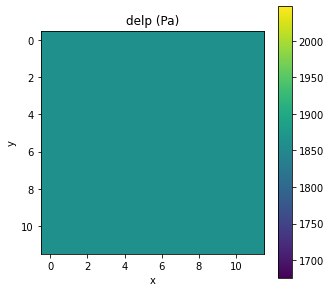

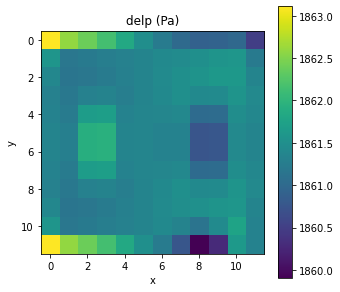

In [6]:
plot(dycore_state, "delp")
driver.step(timedelta(minutes=15))
plot(dycore_state, "delp")

## Demo 2: Regridding Component

The reader-comm driver will play back communications exactly as they occurred when the reference data was created, so we cannot run communication code different from what happened at that time. But we can run code that does not rely on communications. For example, let's look at how the d-grid winds (`u` and `v`) are remapped to a-grid and c-grid winds by `DGrid2AGrid2CGridVectors`.

### Initialize component from driver settings

In [ ]:
d2a2c = fv3core.stencils.d2a2c_vect.DGrid2AGrid2CGridVectors(
    stencil_factory=driver.stencil_factory,
    grid_data=driver.state.grid_data,
    nested=False,
    grid_type=0,
    dord4=True
)

### Call it on a copy of the initial state

In [ ]:
remap_state = copy.deepcopy(initial_state)

In [ ]:
# need temporaries for c-grid contravariant wind multiplied by timestep
utc = driver.quantity_factory.zeros(
    dims=[pace.util.X_DIM, pace.util.Y_DIM, pace.util.Z_DIM], units="m/s"
)
vtc = driver.quantity_factory.zeros(
    dims=[pace.util.X_DIM, pace.util.Y_DIM, pace.util.Z_DIM], units="m/s"
)
d2a2c(
    uc=remap_state.uc,
    vc=remap_state.vc,
    u=remap_state.u,
    v=remap_state.v,
    ua=remap_state.ua,
    va=remap_state.va,
    utc=utc,
    vtc=vtc
)

### Look at re-gridded "meridional" winds

`v` is the wind parallel to tile y-edges, is really meridional.

`va` is wind perpendicular to transport faces, gains nonzero component.

`vc` is wind parallel to tile y-edges but defined on gridcell edges, is poorly defined on tile edges

In [ ]:
plot(remap_state, "v")
plot(remap_state, "va")
plot(remap_state, "vc")

![Cubed-sphere grid](https://www.researchgate.net/profile/David-Williamson-4/publication/224017908/figure/fig3/AS:651142501498881@1532255878448/A-cubed-sphere-grid-obtained-by-projecting-a-Cartesian-coordinate-system-on-each-face.png)